# Tutorial 03

*   Training neural networks in PyTorch
*   Debugging and analyzing overfitting/underfitting

## Neural Networks 

*   Input (features): **x**
*   Output (labels/target values): **y**
*   We want to find a function **f** that will approximate **f(x) = y** and can be run on new data when **y** is unknown

Neural networks approximate the function **f** by composition of functions like

$$ f(x) = f^{(N)}(...f^{(2)}(f^{(1)}(x)))$$

where N is number of layers of the neural network

## Multilayer Perceptron (MLP)

Let's define an ${ f^{(i)}(x) }$ function like

$$ f^{(i)}(x) = \phi(\textbf{W}x + b) $$

where ${x \in \mathbb{R}^{D} }$ is an input vector, ${ \textbf{W} \in \mathbb{R}^{d \times D} }$ is weight matrix, ${ d \in \mathbb{R}^{d} }$ is bias vector to be added, and ${\phi(.)}$ is an activation function.

MLPs are a class of neural network where ${ f_{(i)} }$ is defined like the above. A simple MLP with 2 layers are illustrated in Figure 1

[![MLP Figure 1](https://classic.d2l.ai/_images/mlp.svg)]()
 *Figure 1: A Simple MLP*

 Two of the most commonly used activations are *sigmoid* and *ReLU* functions

 <!-- $$ Sigmoid: \sigma(x) = \frac{1}{1 + e^{-x}} $$
 $$ ReLU: R(x) = max(0, x) $$ -->

  
[![Sigmoid and ReLU figure](https://miro.medium.com/max/1452/1*XxxiA0jJvPrHEJHD4z893g.png )]()



ReLU, only pooint of non linearity at 0 -> introduces non linearity to function

# Download the Dataset
We are using cats vs. dogs dataset used in Tutorial 01. You may download it from [here](https://www.floydhub.com/swaroopgrs/datasets/dogscats) and extract it to your working folder. Alternatively, you can just run the cell below to download and extract it. If you are not running the notebook on Google Colab, make sure that you have gdown by using the command `pip install gdown`. If you are on Windows, the cell won't work. You need to download and extract the data from the link. 

In [1]:
!gdown --id 1sKjxoH-MQl3CBVEm6C0EHwV3rqtXOqWq
!tar -xf swaroopgrs-datasets-dogscats-1.tar

/Users/andrechung/Desktop/University/DL/.dl/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1sKjxoH-MQl3CBVEm6C0EHwV3rqtXOqWq
From (redirected): https://drive.google.com/uc?id=1sKjxoH-MQl3CBVEm6C0EHwV3rqtXOqWq&confirm=t&uuid=f0036266-a376-4e2e-9c73-668dcefb5101
To: /Users/andrechung/Desktop/University/DL/Tutorial 3/swaroopgrs-datasets-dogscats-1.tar
100%|████████████████████████████████████████| 887M/887M [00:24<00:00, 36.8MB/s]


# Training neural networks
We have a set of input vectors $x$ (features) and desired targets (value / class label) $y$  
We want to find a function $f$ such that $f(x)=y$

Basic training algorithm:  
**Input:**
- features $x$, targets $y$  
- neural network model with randomly initialized parameters $\theta$: $f(x; \theta)$  
- learning_rate $\alpha$  
- loss function $L$  

**Output:**
- optimized parameters $\theta$

**Algorithm**  
>for epoch in 1..n_epochs do
>>     for (minibatch_x, minibatch_y) in dataset do
>>>        compute predicted y' = f(x; theta)
>>>        compute loss = L(y', minibatch_y)
>>>        compute gradients = gradient(L, theta)
>>>        update parameters theta <- theta - learning_rate * gradients

First, set device variable to `cuda` if there is an availabe GPU, otherwise it will be set to `cpu`.

In [2]:
import torch
from tqdm.notebook import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

Device: cpu


# Dataset
We are defining the dataset object so that Pytorch shall know how to load the dataset, we are using `ImageFolder` class of Pytorch, which puts images in the subfolders of `root_dir` to different classes. Since we have two folder called "cats" and "dogs", we'll have two classes for cats and dogs.

In [3]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
root_dir = 'images'

target_size = (32, 32)
transforms = Compose([Resize(target_size), # Resizes image
                      ToTensor(),           # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                      Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5)), # scales to [-1.0, 1.0]
                    ])

train_dataset_ = ImageFolder('train', transform=transforms)
val_dataset_ = ImageFolder('valid', transform=transforms)

In [4]:
print('Number of training samples: {}'.format(len(train_dataset_)))
print('Number of validation samples: {}'.format(len(val_dataset_)))

Number of training samples: 23000
Number of validation samples: 2000


# Load the Dataset
Instead of loading opening image files one by one, we'll load them to memory in the beginning so that the training would be faster. (if enough RAM)

In [5]:

from dataset_wrapper import RAMDatasetWrapper
"""
class RAMDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset):
        data = []
        for sample in tqdm(dataset):
            data.append(sample)
        self.n = len(dataset)
        self.data = data
        
    def __getitem__(self, ind):
        return self.data[ind]

    def set_transform(self, transform):
        self.transform = transform
    
    def __len__(self):
        return self.n
"""

'\nclass RAMDatasetWrapper(torch.utils.data.Dataset):\n    def __init__(self, dataset):\n        data = []\n        for sample in tqdm(dataset):\n            data.append(sample)\n        self.n = len(dataset)\n        self.data = data\n        \n    def __getitem__(self, ind):\n        return self.data[ind]\n\n    def set_transform(self, transform):\n        self.transform = transform\n    \n    def __len__(self):\n        return self.n\n'

In [6]:
%matplotlib inline

import numpy as np
import torch
from tqdm import tqdm
"""
# Define mode_to_nptype dictionary if not already defined
mode_to_nptype = {
    "1": np.uint8,
    "L": np.uint8,
    "P": np.uint8,
    "RGB": np.uint8,
    "RGBA": np.uint8,
    "CMYK": np.uint8,
    "YCbCr": np.uint8,
    "I": np.int32,
    "F": np.float32,
}
"""

'\n# Define mode_to_nptype dictionary if not already defined\nmode_to_nptype = {\n    "1": np.uint8,\n    "L": np.uint8,\n    "P": np.uint8,\n    "RGB": np.uint8,\n    "RGBA": np.uint8,\n    "CMYK": np.uint8,\n    "YCbCr": np.uint8,\n    "I": np.int32,\n    "F": np.float32,\n}\n'

In [7]:
train_dataset = RAMDatasetWrapper(train_dataset_)

100%|██████████| 23000/23000 [00:58<00:00, 394.87it/s]


In [8]:
import numpy as np
print(np.__version__)
import sys
print(sys.executable)

1.26.4
/Users/andrechung/Desktop/University/DL/.dl/bin/python


In [9]:
type(train_dataset)

dataset_wrapper.RAMDatasetWrapper

# Random Sample
Let's pick a random sample from dataset and visualize it with matplotlib

Text(0.5, 1.0, 'It is a dog')

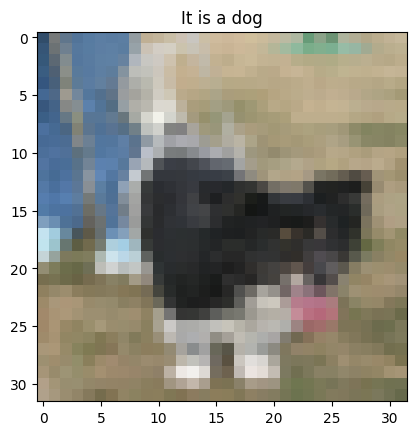

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

index = np.random.randint(0, high=len(train_dataset))
img_to_show = train_dataset[index][0].mul(0.5).add(0.5).permute(1,2,0).cpu().numpy()
label_sample = train_dataset[index][1]
label_dict = {0: 'cat', 1: 'dog'}

plt.imshow(img_to_show)
plt.title('It is a {}'.format(label_dict[label_sample]))

# Dataloaders
Defining the dataloaders for training and validation datasets. This object will do loading of the dataset with desired batch size and shuffles the data.

In [11]:
from torch.utils.data import DataLoader
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2) #num_workers = n - how many threads in background for efficient loading

In [12]:
# Same for validation dataset
val_dataset = RAMDatasetWrapper(val_dataset_)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 2000/2000 [00:05<00:00, 399.21it/s]


# Define the Models
We are declearing the one linear model and one MLP model that we are going to use through this tutorial by inhereting the Pytorch's `nn.Module` class. The input images are converted into 1D vectors in both models, then a binary prediction is made to conclude that the image is cat or dog 

In [13]:
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearModel, self).__init__()
        self.fc = nn.Linear(input_dim, 2, bias=True) # outputs 2 values - score for cat and score for dog
        
    def forward(self, input):
        out = input.view(input.size(0), -1) # convert batch_size x 3 x imH x imW to batch_size x (3*imH*imW)
        out = self.fc(out) # Applies out = input * A + b. A, b are parameters of nn.Linear that we want to learn
        return out
    
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim ,hidden_dim, bias=True)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim ,hidden_dim, bias=True)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim ,2, bias=True)
        layer = []
        for i in range(num_layers):
            if i == 0:
                layer.append(nn.Linear(input_dim, hidden_dim, bias=True))
                layer.append(nn.ReLU())
            elif i == num_layers-1:
                layer.append(nn.Linear(hidden_dim, 2))
            else:
                layer.append(nn.Linear(hidden_dim, hidden_dim, bias=True))
                layer.append(nn.ReLU())
        
        self.net=nn.Sequential(*layer)

        
    def forward(self, input):
        out = input.view(input.size(0), -1)
        out = self.net(out)
        return out


In [14]:
model = MLPModel(100,200,4)
model

MLPModel(
  (fc1): Linear(in_features=100, out_features=200, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (act3): ReLU()
  (fc4): Linear(in_features=200, out_features=2, bias=True)
  (net): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)

# Training Functions
We are declaring the functions that we'll use for training. `train_epoch` function performs the the training for one epoch, `train` function trains the model for the desired number of epochs. 

In [15]:
import numpy as np

def train_epoch(model, train_dataloader, optimizer, loss_fn):
    losses = []
    correct_predictions = 0
    # Iterate mini batches over training dataset
    for images, labels in tqdm(train_dataloader):
        # move tensors to current device
        images = images.to(device)
        labels = labels.to(device)
     
        # Run predictions
        output= model(images)
        
        # Set gradients to zero
        # https://pytorch.org/docs/stable/optim.html
        # https://discuss.pytorch.org/t/why-do-we-need-to-set-the-gradients-manually-to-zero-in-pytorch/4903/20
        # otherwise previous gradients would be accumulated and training won't work
        optimizer.zero_grad()   
        
        # Compute loss
        loss= loss_fn(output, labels)
        
        # Backpropagate (compute gradients)
        loss.backward()

        #Pytorch already know what is the gradient, stored in the .grad
        
        # Make an optimization step (update parameters)
        optimizer.step()
        
        # Log metrics
        losses.append(loss.item())
        predicted_labels = output.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
    accuracy = 100.0 * correct_predictions / len(train_dataloader.dataset)
    # Return loss values for each iteration and accuracy
    mean_loss = np.array(losses).mean()
    return mean_loss, accuracy

In [16]:
def evaluate(model, dataloader, loss_fn):
    losses = []
    correct_predictions = 0
    with torch.no_grad(): # Disable gradient tracking, context manager, 
        # changes contextt in which the code is executed-> no gradient tracking
        # saves some computation and storage (no grad)        
        for images, labels in dataloader:
            
            #move tensors to current device
            images = images.to(device)
            labels = labels.to(device)
            
            
            # Run predictions
            output = model(images)
            
            
            # Compute loss
            loss = loss_fn(output, labels)
            
            
            predicted_labels = output.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
            losses.append(loss.item())
    mean_loss = np.array(losses).mean()
    accuracy = 100.0 * correct_predictions / len(dataloader.dataset)
    # Return mean loss and accuracy
    return mean_loss, accuracy

In [17]:
def train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        # set model to train mode
        model.train()
        
        # train the model for one epoch
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_function)
        
        # set the model to eval model
        model.eval()
        
        # evaluate the model with validation data
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_function)
        
        # append losses and accuracies
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))
    return train_losses, val_losses, train_accuracies, val_accuracies

# Plotting
We are defining the plot function to plot the loss vs. epoch and accuracy vs. epoch graphs. The loss and accuracy for training and validation dataset are plotted on the same graph. 

In [18]:
def plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(np.arange(n_epochs), train_losses)
    plt.plot(np.arange(n_epochs), val_losses)
    plt.legend(['train_loss', 'val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss value')
    plt.title('Train/val loss')

    plt.figure()
    plt.plot(np.arange(n_epochs), train_accuracies)
    plt.plot(np.arange(n_epochs), val_accuracies)
    plt.legend(['train_acc', 'val_acc'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Train/val accuracy')


# Linear Model training


In [19]:
model = LinearModel(32*32*3)
model = model.to(device)

n_epochs = 10
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()


# Train the linear model
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function)

100%|██████████| 360/360 [00:11<00:00, 31.46it/s]


Epoch 1/10: train_loss: 0.6781, train_accuracy: 57.7957, val_loss: 0.6812, val_accuracy: 58.1000


100%|██████████| 360/360 [00:08<00:00, 42.52it/s] 


Epoch 2/10: train_loss: 0.6635, train_accuracy: 60.2739, val_loss: 0.6782, val_accuracy: 59.0500


100%|██████████| 360/360 [00:08<00:00, 42.06it/s] 


Epoch 3/10: train_loss: 0.6602, train_accuracy: 60.5609, val_loss: 0.6671, val_accuracy: 62.0000


100%|██████████| 360/360 [00:08<00:00, 42.68it/s] 


Epoch 4/10: train_loss: 0.6572, train_accuracy: 61.2609, val_loss: 0.6531, val_accuracy: 61.9500


100%|██████████| 360/360 [00:08<00:00, 42.90it/s] 


Epoch 5/10: train_loss: 0.6540, train_accuracy: 61.5739, val_loss: 0.6509, val_accuracy: 62.2000


100%|██████████| 360/360 [00:08<00:00, 43.19it/s] 


Epoch 6/10: train_loss: 0.6530, train_accuracy: 61.7522, val_loss: 0.6584, val_accuracy: 61.1500


100%|██████████| 360/360 [00:08<00:00, 42.72it/s] 


Epoch 7/10: train_loss: 0.6501, train_accuracy: 62.4739, val_loss: 0.6679, val_accuracy: 61.1500


100%|██████████| 360/360 [00:08<00:00, 43.49it/s] 


Epoch 8/10: train_loss: 0.6484, train_accuracy: 62.7261, val_loss: 0.6751, val_accuracy: 61.9500


100%|██████████| 360/360 [00:08<00:00, 43.45it/s] 


Epoch 9/10: train_loss: 0.6514, train_accuracy: 62.3043, val_loss: 0.6714, val_accuracy: 60.8000


100%|██████████| 360/360 [00:08<00:00, 43.12it/s] 


Epoch 10/10: train_loss: 0.6456, train_accuracy: 62.8304, val_loss: 0.6573, val_accuracy: 61.8000


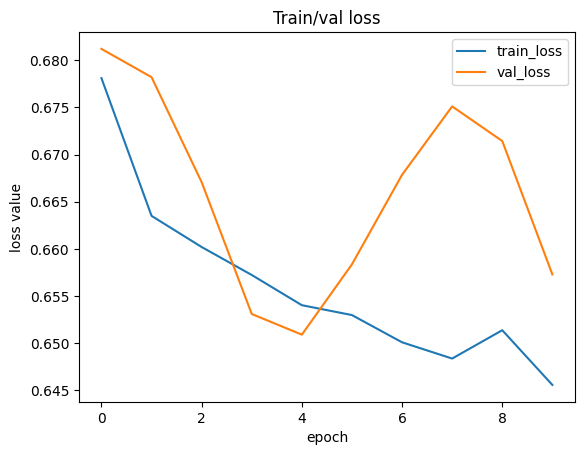

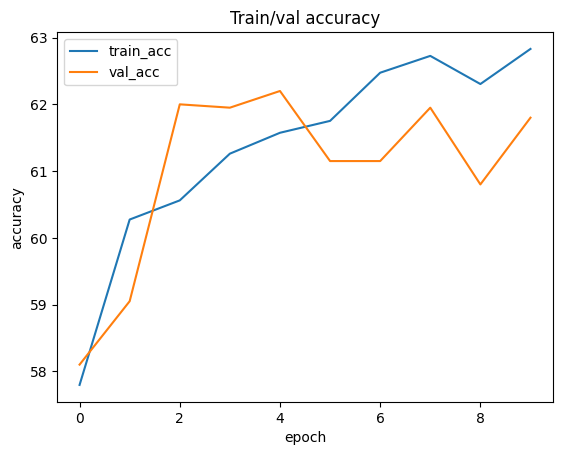

In [20]:
# Visualize losses, accuracies

plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

# MLP training


In [21]:
model = MLPModel(32*32*3, 64, 4)
model = model.to(device)

# Train the MLP model

n_epochs = 10
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function)


100%|██████████| 360/360 [00:09<00:00, 39.95it/s] 


Epoch 1/10: train_loss: 0.6910, train_accuracy: 53.4435, val_loss: 0.6880, val_accuracy: 57.9500


100%|██████████| 360/360 [00:09<00:00, 38.87it/s] 


Epoch 2/10: train_loss: 0.6839, train_accuracy: 58.6478, val_loss: 0.6790, val_accuracy: 59.9000


100%|██████████| 360/360 [00:09<00:00, 39.88it/s] 


Epoch 3/10: train_loss: 0.6711, train_accuracy: 60.8261, val_loss: 0.6647, val_accuracy: 61.1500


100%|██████████| 360/360 [00:08<00:00, 41.19it/s] 


Epoch 4/10: train_loss: 0.6534, train_accuracy: 62.5304, val_loss: 0.6489, val_accuracy: 61.6500


100%|██████████| 360/360 [00:08<00:00, 41.93it/s] 


Epoch 5/10: train_loss: 0.6382, train_accuracy: 63.4783, val_loss: 0.6437, val_accuracy: 62.3000


100%|██████████| 360/360 [00:08<00:00, 41.60it/s] 


Epoch 6/10: train_loss: 0.6257, train_accuracy: 65.0783, val_loss: 0.6340, val_accuracy: 64.0500


100%|██████████| 360/360 [00:08<00:00, 41.80it/s] 


Epoch 7/10: train_loss: 0.6158, train_accuracy: 65.7043, val_loss: 0.6270, val_accuracy: 64.8000


100%|██████████| 360/360 [00:08<00:00, 41.17it/s] 


Epoch 8/10: train_loss: 0.6052, train_accuracy: 67.0696, val_loss: 0.6207, val_accuracy: 64.9500


100%|██████████| 360/360 [00:08<00:00, 40.43it/s] 


Epoch 9/10: train_loss: 0.5964, train_accuracy: 67.6739, val_loss: 0.6123, val_accuracy: 65.8000


100%|██████████| 360/360 [00:08<00:00, 41.26it/s] 


Epoch 10/10: train_loss: 0.5875, train_accuracy: 68.6304, val_loss: 0.6175, val_accuracy: 66.0500


([0.6909742179844115,
  0.6838771238923073,
  0.6711136110954814,
  0.6534192835291227,
  0.6382098469469283,
  0.6257028217944834,
  0.6158076167106629,
  0.6052344597876071,
  0.5964096388883061,
  0.5874570349852244],
 [0.6880331356078386,
  0.6790077369660139,
  0.6646960116922855,
  0.6489348020404577,
  0.6436670050024986,
  0.6340454574674368,
  0.6269788946956396,
  0.6207413952797651,
  0.6123067364096642,
  0.617544581182301],
 [53.44347826086957,
  58.64782608695652,
  60.82608695652174,
  62.530434782608694,
  63.47826086956522,
  65.07826086956521,
  65.70434782608696,
  67.0695652173913,
  67.67391304347827,
  68.6304347826087],
 [57.95, 59.9, 61.15, 61.65, 62.3, 64.05, 64.8, 64.95, 65.8, 66.05])

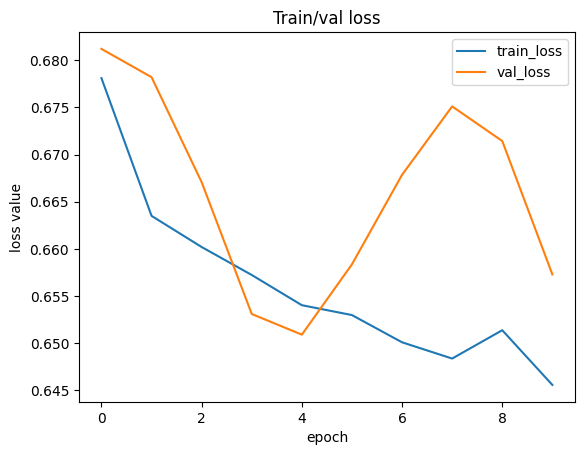

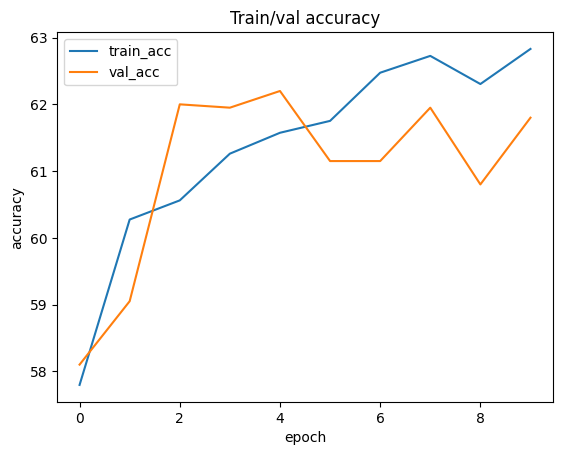

In [22]:
# Visualize losses, accuracies

plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

Overfitting

Train = accurate but not validation